In [3]:
import pandas as pd
import seaborn as sns
import wave
import librosa
import numpy as np
import scipy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import IPython.display as ipd  # to play sound in notebook

from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from sklearn.metrics import confusion_matrix

%matplotlib inline

iva作为test数据的提取

In [12]:
X_test_fnames = []
X_test_labels = []
file_list1 = os.listdir("D:\\test\\Ivanova\\AD") 
file_list2 = os.listdir("D:\\test\\Ivanova\\HC") 
for f in file_list1:
    X_test_fnames.append(f)
    X_test_labels.append(1)

for f in file_list2:
    X_test_fnames.append(f)
    X_test_labels.append(0)

# print(len(X_train_fnames))
# print(len(X_test_labels))
# print(X_train_fnames)
# print(X_test_labels)


train数据的提取

In [19]:
base_path = "./output/"
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
train_labels_path = os.path.join(base_path,'training-groundtruth.csv')
train_df = pd.read_csv(train_labels_path)
train_base_path = os.path.join(base_path, 'train')
test_base_path = os.path.join(base_path, 'test')

X_train_labels = np.array(train_df['dx'])
encoder = LabelEncoder()
encoder.fit(X_train_labels)
X_train_fnames = np.array(train_df['adressfname'])
X_train_labels = encoder.transform(X_train_labels)

X_train_fnames = [f + '.wav' for f in X_train_fnames]
print(len(X_train_fnames))
print(len(X_train_labels))
print(len(X_test_fnames))
print(len(X_test_labels))
# print(X_test_fnames)
# print(X_test_labels)

237
237
271
271


mfcc的config配置

In [15]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=10, 
                 learning_rate=0.0001, max_epochs=20, n_mfcc=40):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.audio_length = self.sampling_rate * self.audio_duration
        self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)

def prepare_data(fnames, config, data_dir):
    X = np.empty(shape=(len(fnames), config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        file_path = os.path.join(data_dir, fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [ ]:
训练所用的模型

In [16]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,4), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*2, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

结果绘图

In [17]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");

def plot_loss(history):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()
def plot_acc(history):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10,7))
    plt.plot(history.history['acc'], c ="darkblue")
    plt.plot(history.history['val_acc'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model acc")
    plt.xlabel("Epoch")
    plt.ylabel("acc")
    plt.grid(True, alpha = 0.2)
    plt.show()

train和test数据的整理归一化

In [29]:
config = Config(sampling_rate=16000, audio_duration=30, learning_rate=0.0001, n_mfcc=40, n_classes=2)
X_train = prepare_data(X_train_fnames, config, train_base_path)
y_train = to_categorical(X_train_labels, num_classes=config.n_classes)

X_test = prepare_data(X_test_fnames, config, test_base_path)
y_test = to_categorical(X_test_labels, num_classes=config.n_classes)


mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):


  0%|          | 0/237 [00:00<?, ?it/s]

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-1.1901855e-03  2.8381348e-03  3.5400391e-03 ... -3.0517578e-05
 -6.1035156e-05 -2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.01245117 -0.01904297 -0.02609253 ...  0.00378418  0.00167847
 -0.00314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.0055542  -0.00500488 -0.00567627 ...  0.01477051  0.01351929
  0.01068115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00524902  0.00485229  0.00369263 ... -0.00140381 -0.00234985
 -0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 5.7983398e-04 -1.5258789e-04  9.1552734e-05 ...  6.1035156e-04
  1.7395020e-03  2.5329590e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mf

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.0010376  0.00131226 0.00088501 ... 0.00067139 0.0010376  0.00146484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00088501  0.00085449 -0.00128174 ...  0.00247192  0.0039978
  0.00497437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-1.9958496e-02 -1.9134521e-02 -1.8859863e-02 ... -3.0517578e-05
  6.1035156e-05  6.4086914e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data,

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.01156616 -0.00656128 -0.02359009 ... -0.00802612 -0.00744629
 -0.00985718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00164795 -0.00439453 -0.00772095 ... -0.00939941 -0.00891113
 -0.00674438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.01190186  0.00527954 -0.00140381 ... -0.09759521 -0.09143066
 -0.08395386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.07122803  0.16778564  0.23080444 ... -0.13391113 -0.19393921
 -0.2381897 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00088501 -0.0010376  -0.00094604 ...  0.00125122  0.00204468
  0.0032959 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-1.4038086e-03  9.1552734e-05 -2.4108887e-03 ...  1.8310547e-03
 -4.2114258e-03 -6.0729980e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mf

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00280762 -0.00286865 -0.00241089 ...  0.00131226  0.00189209
  0.00253296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00064087 -0.00030518 -0.00018311 ... -0.00061035 -0.00064087
 -0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00057983  0.00195312  0.00268555 ... -0.00402832 -0.00445557
 -0.0039978 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00445557 -0.00283813 -0.00164795 ... -0.00811768 -0.01434326
 -0.02163696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00259399 -0.00537109 -0.01095581 ... -0.00790405 -0.00708008
 -0.00894165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.01361084 -0.00976562 -0.00479126 ... -0.02151489 -0.01370239
  0.00085449] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.04953003 -0.04901123 -0.04733276 ... -0.00036621 -0.00088501
 -0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00012207  0.00027466  0.00027466 ...  0.00048828  0.00054932
  0.00045776] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.01513672 -0.01742554 -0.01937866 ...  0.00085449  0.00067139
  0.00100708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 9.1552734e-03  1.1016846e-02  1.2390137e-02 ...  3.0517578e-05
 -3.0517578e-04 -8.5449219e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00595093 -0.00283813 -0.00244141 ... -0.00558472 -0.0010376
  0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00039673 -0.00033569 -0.00036621 ... -0.00076294 -0.00073242
 -0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfc

  0%|          | 0/271 [00:00<?, ?it/s]

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.00048828 0.00061035 0.00085449 ... 0.00881958 0.00939941 0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.00109863 0.00146484 0.00112915 ... 0.00183105 0.00213623 0.00250244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.05386353 -0.04840088 -0.05505371 ...  0.08294678  0.09075928
  0.09545898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.0390625  -0.04016113 -0.02825928 ... -0.1192627  -0.10507202
 -0.11611938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.02804565 0.0300293  0.01483154 ... 0.03933716 0.02893066 0.01486206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.4187622  -0.46777344 -0.46292114 ...  0.01803589  0.0206604
  0.01095581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.samplin

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.00704956 -0.00656128 -0.00808716 ... -0.01083374 -0.01980591
 -0.00314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.18597412 -0.16088867 -0.13461304 ...  0.03329468  0.04141235
  0.04104614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.00234985 0.0005188  0.00250244 ... 0.04351807 0.0447998  0.04620361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampli

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00671387  0.00534058  0.00460815 ... -0.00973511 -0.01025391
 -0.00717163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.0218811  -0.01293945 -0.00344849 ... -0.5794678  -0.5706482
 -0.42364502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.04910278 0.05184937 0.05331421 ... 0.08346558 0.08810425 0.08633423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.samplin

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.11376953  0.13034058  0.1512146  ... -0.01062012 -0.0184021
 -0.02124023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00042725 -0.00167847 -0.00134277 ...  0.00115967 -0.00106812
 -0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.0027771  -0.00219727 -0.00109863 ...  0.00384521  0.00512695
  0.00021362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.32843018  0.3327942   0.29800415 ... -0.00634766 -0.00579834
 -0.0017395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.01052856 -0.03292847 -0.05264282 ... -0.01296997 -0.01394653
 -0.01327515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00073242  0.00012207 -0.00067139 ...  0.00106812  0.00158691
 -0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.01525879  0.01791382  0.0249939  ...  0.01226807 -0.02246094
  0.00674438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 1.1291504e-03 -6.1035156e-05 -8.8500977e-03 ...  3.4790039e-03
  1.7089844e-03 -1.1901855e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.1791687  -0.11941528 -0.03793335 ... -0.00759888 -0.01211548
 -0.02435303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mf

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.01092529  0.00701904  0.01199341 ... -0.00067139  0.0005188
  0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.00497437  0.00561523  0.00622559 ... -0.00363159 -0.00262451
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[ 0.03747559  0.0380249   0.03915405 ... -0.01501465 -0.01062012
 -0.01089478] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.

C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[-0.01086426  0.00338745  0.02954102 ...  0.00778198  0.00595093
  0.00302124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.0166626  0.01205444 0.00964355 ... 0.03198242 0.04025269 0.04675293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
C:\Users\gwc\AppData\Local\Temp\ipykernel_31088\978627841.py:34: FutureWarning: Pass y=[0.01467896 0.02609253 0.03363037 ... 0.06088257 0.06820679 0.07696533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.feature.mfcc(data, sr=config.sampling_rate

In [30]:
print(X_train.shape)
print(X_test.shape)

(237, 40, 938, 1)
(271, 40, 938, 1)


In [35]:
config = Config(sampling_rate=16000, audio_duration=30, learning_rate=0.0001, n_mfcc=40, n_classes=2)
model = get_2d_conv_model(config)

In [36]:
import datetime
log_dir = os.path.join(base_path,'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
from keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True)

In [37]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=8,
                    callbacks=[tensorboard_callback],
                    epochs=100)

Epoch 1/100
30/30 [==============================] - 29s 940ms/step - loss: 0.8459 - acc: 0.5316 - val_loss: 0.7658 - val_acc: 0.2952
Epoch 2/100
30/30 [==============================] - 28s 930ms/step - loss: 0.3061 - acc: 0.9030 - val_loss: 0.8476 - val_acc: 0.2989
Epoch 3/100
30/30 [==============================] - 29s 963ms/step - loss: 0.1787 - acc: 0.9409 - val_loss: 0.8904 - val_acc: 0.2878
Epoch 4/100
30/30 [==============================] - 29s 961ms/step - loss: 0.1212 - acc: 0.9831 - val_loss: 0.8869 - val_acc: 0.3137
Epoch 5/100
30/30 [==============================] - 30s 992ms/step - loss: 0.0998 - acc: 0.9873 - val_loss: 0.9718 - val_acc: 0.3210
Epoch 6/100
30/30 [==============================] - 30s 1s/step - loss: 0.1045 - acc: 0.9831 - val_loss: 0.9251 - val_acc: 0.3616
Epoch 7/100
30/30 [==============================] - 28s 922ms/step - loss: 0.1060 - acc: 0.9747 - val_loss: 1.0760 - val_acc: 0.3506
Epoch 8/100
30/30 [==============================] - 28s 924ms/st

Epoch 62/100
30/30 [==============================] - 28s 931ms/step - loss: 0.0669 - acc: 0.9789 - val_loss: 1.0525 - val_acc: 0.6347
Epoch 63/100
30/30 [==============================] - 28s 929ms/step - loss: 0.0620 - acc: 0.9873 - val_loss: 0.9007 - val_acc: 0.6753
Epoch 64/100
30/30 [==============================] - 28s 930ms/step - loss: 0.1079 - acc: 0.9578 - val_loss: 0.8436 - val_acc: 0.6310
Epoch 65/100
30/30 [==============================] - 28s 933ms/step - loss: 0.0866 - acc: 0.9705 - val_loss: 0.8887 - val_acc: 0.6716
Epoch 66/100
30/30 [==============================] - 28s 939ms/step - loss: 0.0311 - acc: 0.9916 - val_loss: 1.0599 - val_acc: 0.5572
Epoch 67/100
30/30 [==============================] - 28s 935ms/step - loss: 0.0317 - acc: 1.0000 - val_loss: 0.8153 - val_acc: 0.6827
Epoch 68/100
30/30 [==============================] - 28s 939ms/step - loss: 0.0505 - acc: 0.9916 - val_loss: 0.8058 - val_acc: 0.6347
Epoch 69/100
30/30 [==============================] - 2

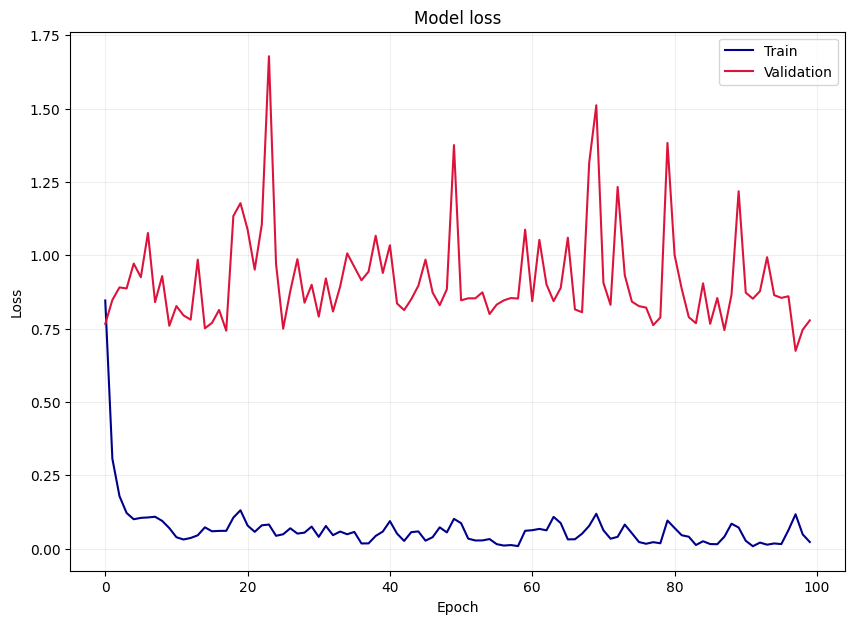

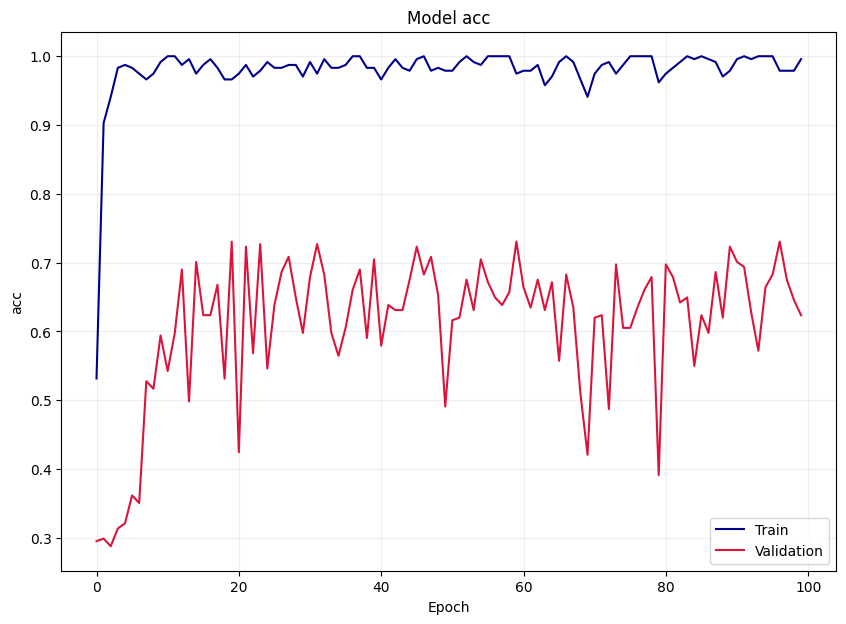

In [38]:
plot_loss(history)
plot_acc(history)